# Flight Data - Network Analysis

In [1]:
%matplotlib inline

# Imports 
import os
import pandas as pd
import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt

In [2]:
# Import custom code
import fld.io as flio

In [3]:
# Set dat path
dat_path = "/Users/thomasdonoghue/Documents/UCSD/1-Classes/2016-2017/" \
           "2-Winter/CSE255_WebMining/Assignments/Assgn-2/Data/"

In [4]:
# Load data for airports and airlines
airlines_df = pd.read_csv(os.path.join(dat_path, 'airlines.csv'))
airports_df = pd.read_csv(os.path.join(dat_path, 'airports.csv'))

In [5]:
# Check out the airports
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [6]:
# Load flight data
flights_df = pd.read_csv(os.path.join(dat_path, 'flights.csv'))

In [7]:
# Flights - Select busy airports
flights_df = flio.select_busy_airports(flights_df)

# Airports - Select busy airports
used_airports = set(flights_df.ORIGIN_AIRPORT.values)
airports_df = airports_df[airports_df.apply(lambda row: row['IATA_CODE'] in used_airports, axis=1)]

In [8]:
# Check out flights
flights_df.head()

,Unnamed: 0,Unnamed: 0.1,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,2015,1,1,4,AS,98,N407AS,ANC,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2015,1,1,4,US,840,N171US,SFO,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2015,1,1,4,AA,258,N3HYAA,LAX,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2015,1,1,4,AS,135,N527AS,SEA,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Extract all aiports present in the data
airports = set(airports_df['IATA_CODE'])

In [10]:
# Extract latitude and longitude for each airport
lats = OrderedDict(); lons = OrderedDict()
for i, row in airports_df.iterrows():
    lats[row['IATA_CODE']] = row['LATITUDE']
    lons[row['IATA_CODE']] = row['LONGITUDE']

In [11]:
# Calculate matrix of flightpaths
flightpaths_df = pd.crosstab(flights_df.loc[:, 'ORIGIN_AIRPORT'],
                             flights_df.loc[:, 'DESTINATION_AIRPORT'])

In [12]:
# Get all 'edges' (all airports with flights between them)
edges = []
#edges_w = []
edges_w = dict()
for air_arr in airports:
    
    fl_paths = flightpaths_df[flightpaths_df[air_arr] > 0].index.tolist()
    
    for air_dep in fl_paths:
        edges.append((air_dep, air_arr))
        #edges_w.append([(air_dep, air_arr), flightpaths_df.loc[air_dep].loc[air_arr]])
        edges_w[(air_dep, air_arr)] = flightpaths_df.loc[air_dep].loc[air_arr]

In [13]:
# Undirected (unweighted) Edges - Keep all unique flight paths
und_edges = [list(fs) for fs in {frozenset(ed) for ed in edges}]

# Equivalently:
#uniq = {frozenset(e) for e in edges}
#uniq_edges = [list(e) for e in uniq]

In [14]:
# Directed (unweighted) Edges
dir_edges = set(edges)

In [15]:
# Directed, Weighted Edges
dir_w_edges = edges_w

In [16]:
# Undirected weighted edges
und_w_edges = dict()

for ed in und_edges:
    try: aa = edges_w[(ed[0], ed[1])]
    except KeyError: aa = 0
    try: bb = edges_w[(ed[1], ed[0])]
    except KeyError: bb = 0
    und_w_edges[ed[0], ed[1]] = aa + bb

## Plotting Maps

In [17]:
from mpl_toolkits.basemap import Basemap, cm

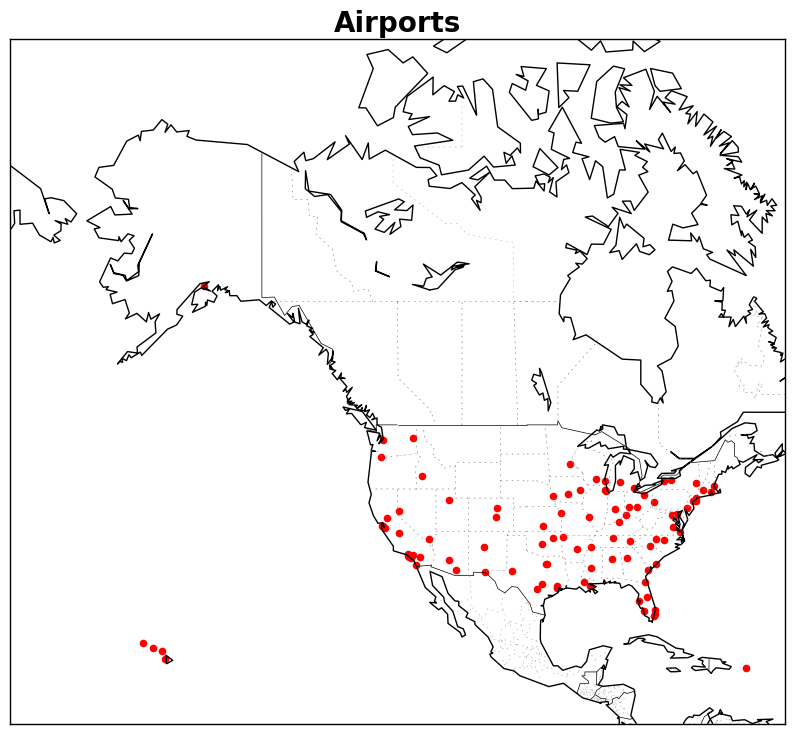

In [18]:
# Plot the mainland airports on a map of the USA

# Figure settings
res = 'c' #
proj = 'merc'

# Initialize figure
fig = plt.figure(figsize=(10, 10))

# Mainland USA only
#m = Basemap(projection=proj, llcrnrlat=24, urcrnrlat=50,\
#            llcrnrlon=-130, urcrnrlon=-60, lat_ts=20, resolution=res)

# All airports (zoom out for Alaska, Hawaii, Peurto Rico)
m = Basemap(projection=proj, llcrnrlat=10, urcrnrlat=75,\
            llcrnrlon=-180, urcrnrlon=-60, lat_ts=20, resolution=res)

# Draw boundaries
m.drawcoastlines()
m.drawcountries()
m.drawstates(linewidth=0.3, linestyle='dotted', color='grey')

# Add point for each airport
x, y = m(list(lons.values()), list(lats.values()))
m.scatter(x, y, 20, marker='o', color='red')

# Add title
plt.title("Airports", {'fontsize': 20, 'fontweight': 'bold'})

## Network Structure

In [19]:
import networkx as nx

In [20]:
lat_lons = dict()
#dd['BSM'] = (-97, 30)
for ind, row in airports_df.iterrows():
    lat_lons[row['IATA_CODE']] = (row['LONGITUDE'], row['LATITUDE'])

In [21]:
# Functions to rescale edge weight to a new range for plotting
# From here: http://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio
def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

In [22]:
# Plotting Settings for all network plots
f_size = (12, 8)
alpha = 0.8
node_size = 40
width = 0.25  # For unweighted graphs

### Undirected, Unweighted Graph

In [23]:
X = nx.Graph()
for ll, p in lat_lons.items():
    X.add_node(ll)
    X.node[ll]['pos'] = p

for e in und_edges:
    X.add_edge(e[0], e[1])

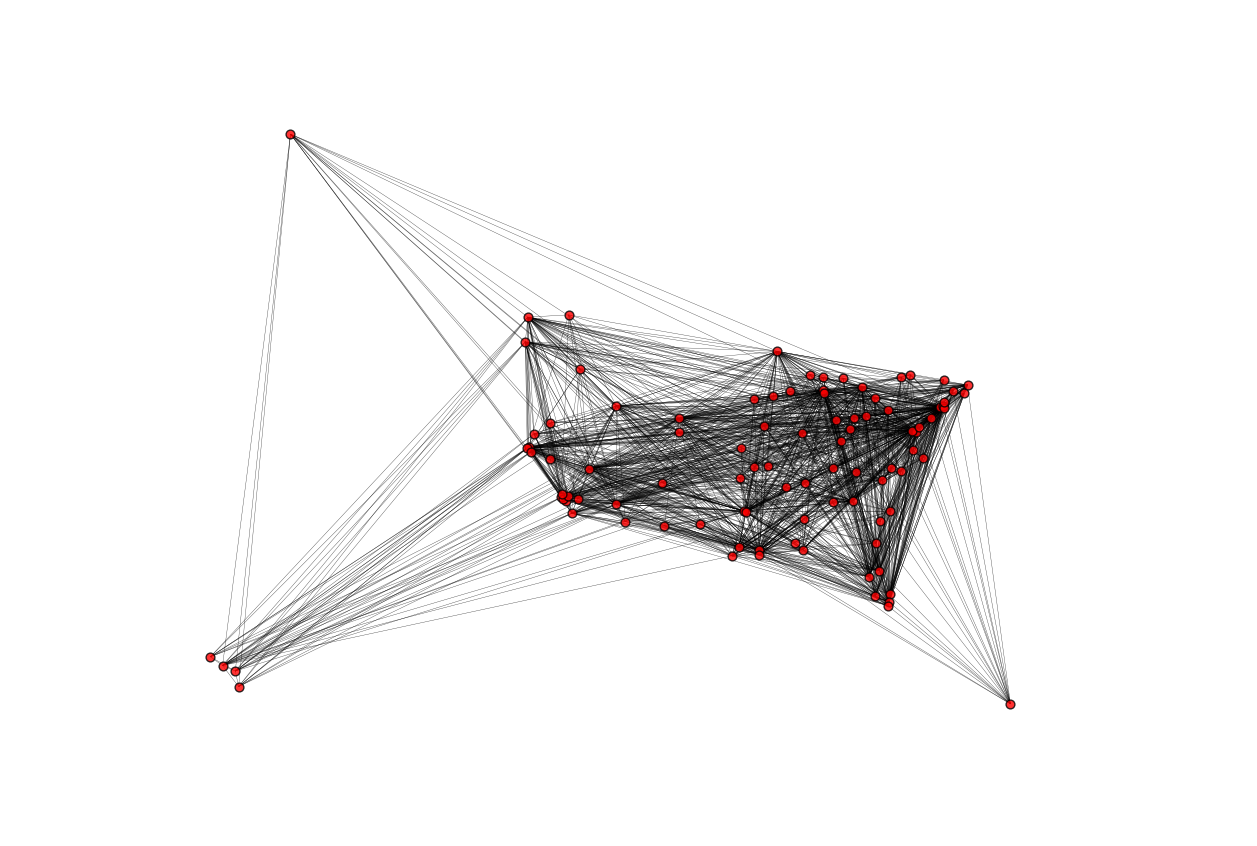

In [24]:
# Plot the graph representation

# Using real locations
plt.figure(figsize=f_size)
nx.draw(X, lat_lons, node_size=node_size, alpha=alpha, width=width)

# Without using real-locations
#nx.draw(X, node_size=50)

In [25]:
# Get node degree
deg = X.degree()

# Calculate average neighbour degree
avg_neigh_deg = nx.average_neighbor_degree(X)

# Calculate closeness centrality
deg_clo_cen = nx.closeness_centrality(X)

# Calculate degree centrality
deg_cen = nx.degree_centrality(X)

In [26]:
# Check out some basic network descriptors
print('Number of nodes is: ', X.number_of_nodes())
print('Number of edges is: ', X.number_of_edges())

Number of nodes is:  98
Number of edges is:  1614


In [27]:
#nx.average_clustering(X)

#nx.average_degree_connectivity(X)

#nx.average_neighbor_degree(X)

#nx.average_shortest_path_length(X)

#nx.betweenness_centrality(X)

#nx.center(X)

#nx.closeness_centrality(X)

#nx.closeness_vitality(X)

#nx.current_flow_betweenness_centrality(X)

#nx.degree_centrality(X)

#nx.eccentricity(X)

#nx.edge_betweenness_centrality(X)

#nx.radius(X)

#nx.shortest_path_length(X)

In [28]:
# ??
spls = nx.shortest_path_length(X)

ids = []
maxs = []
pairs = []
for pp in spls.keys():
    q = max(spls[pp].values())
    maxs.append(q)

    #maxs.append(spls[pp][q])
    #if spls[pp][q] == 4:
    #    pairs.append((pp, q))

### Directed, Unweighted Graph

In [29]:
# Directed, unweighted graph
X_d = nx.DiGraph()
for ll, p in lat_lons.items():
    X_d.add_node(ll)
    X_d.node[ll]['pos'] = p

for e in dir_edges:
    X_d.add_edge(e[0], e[1])

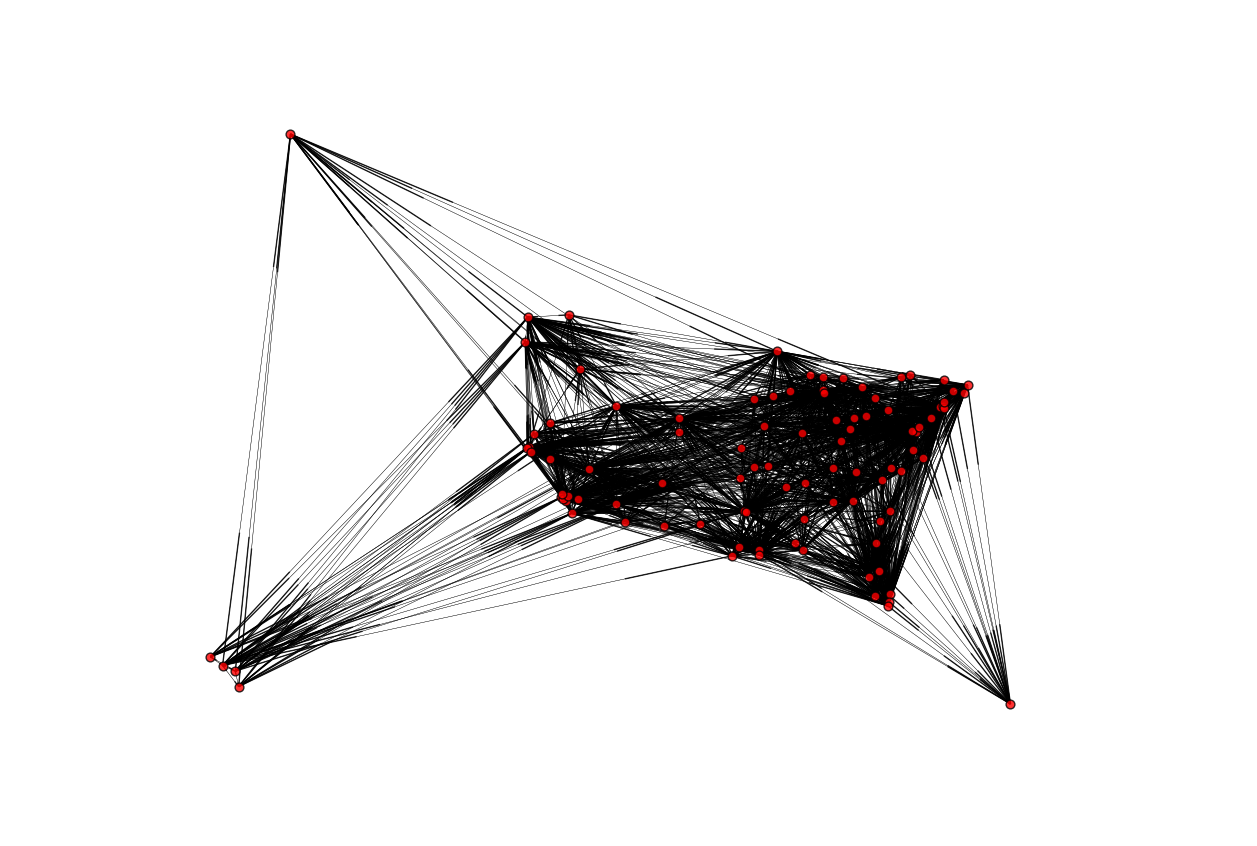

In [30]:
# Plot the graph representation

# Using real locations
plt.figure(figsize=f_size)
nx.draw(X_d, lat_lons, node_size=node_size, alpha=alpha, width=width)

# Without using real-locations
#nx.draw(X, node_size=50)

### Undirected, Weighted Graph

In [31]:
# Directed, weighted graph
X_udw = nx.Graph()
for ll, p in lat_lons.items():
    X_udw.add_node(ll)
    X_udw.node[ll]['pos'] = p

for k, v in und_w_edges.items():
    X_udw.add_edge(k[0], k[1], weight=v)
    #X_udw.add_weighted_edges_from((k[0], k[1], v))

In [32]:
weights = [X_udw[u][v]['weight'] for u,v in X_udw.edges()]
widths = scale_list(weights, 0.1, 3)

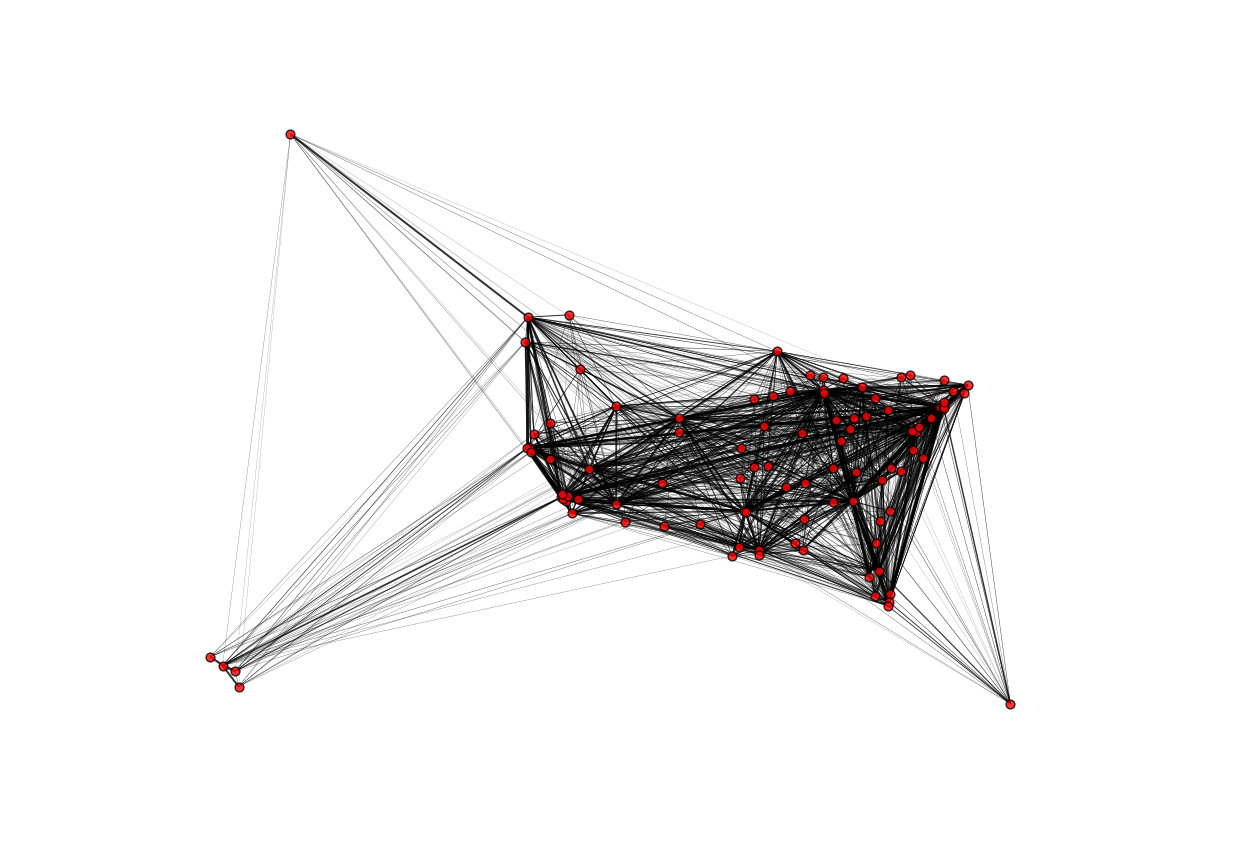

In [33]:
# Plot the graph representation

# Using real locations
plt.figure(figsize=f_size)
nx.draw(X_udw, lat_lons, node_size=node_size, alpha=alpha, width=widths)

# Without using real-locations
#nx.draw(X, node_size=50)

### Directed, Weighted Graph

In [34]:
# Directed, unweighted graph
X_dw = nx.DiGraph()
for ll, p in lat_lons.items():
    X_dw.add_node(ll)
    X_dw.node[ll]['pos'] = p

for k, v in dir_w_edges.items():
    X_dw.add_edge(k[0], k[1], weight=v)

In [35]:
weights = [X_dw[u][v]['weight'] for u,v in X_dw.edges()]
widths = scale_list(weights, 0.1, 3)

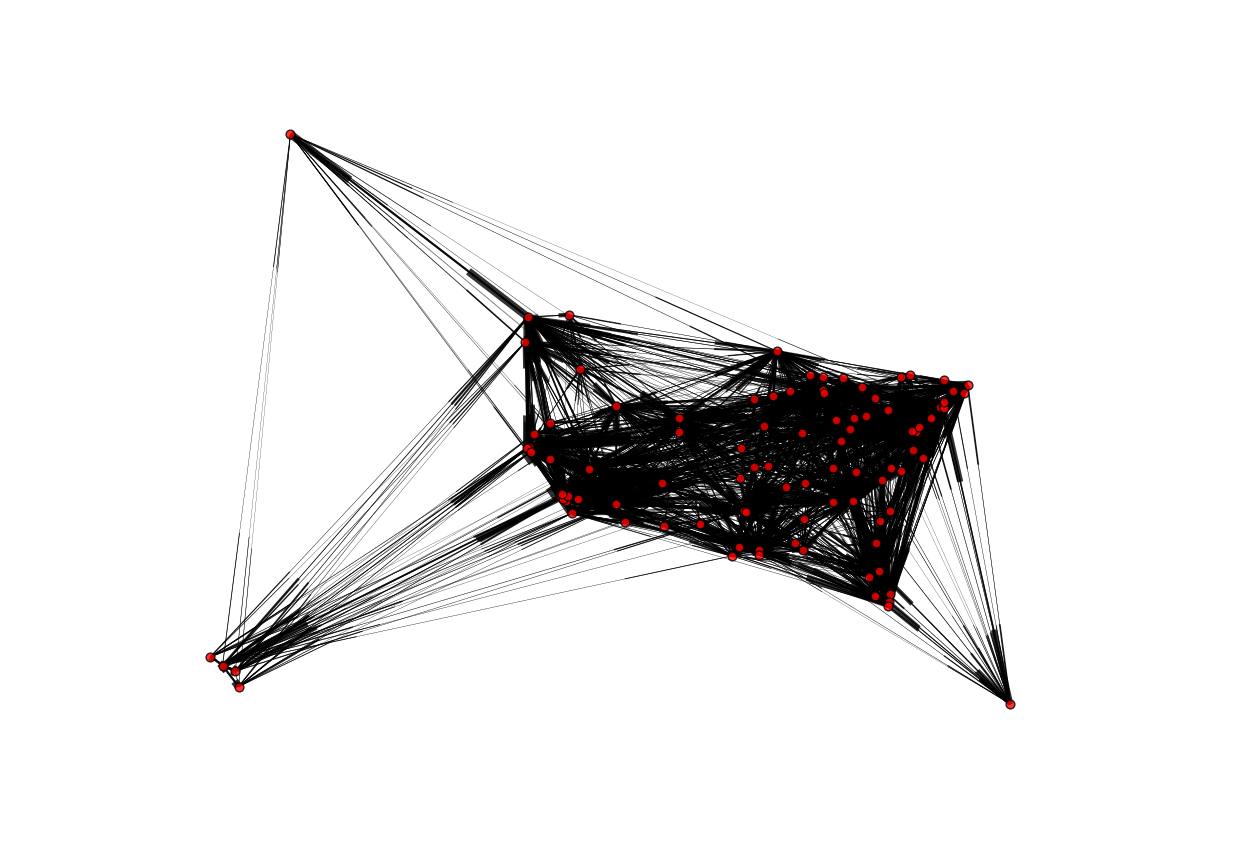

In [36]:
# Plot the graph representation

# Using real locations
plt.figure(figsize=f_size)
nx.draw(X_dw, lat_lons, node_size=node_size, alpha=alpha, width=widths)

# Without using real-locations
#nx.draw(X, node_size=50)

## Distances between airports

In [37]:
# From here: http://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    
    return km

In [38]:
a1 = 'JFK'
a2 = 'LAX'
haversine(lons[a1], lats[a1], lons[a2], lats[a2])

3971.7037653629322

## Add Network Metrics to Airports

In [39]:
# Add airport network information to airlines data
airports_df['DEG'] = airports_df['IATA_CODE'].map(deg)
airports_df['NE_DEG'] = airports_df['IATA_CODE'].map(avg_neigh_deg)
airports_df['CLO_CEN'] = airports_df['IATA_CODE'].map(deg_clo_cen)
airports_df['CEN'] = airports_df['IATA_CODE'].map(deg_cen)

In [40]:
# Save out new airports data to use for prediction
airports_df.to_json('new_airports.json')